In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py

In [2]:
class HDF5ImageDiffDataset(Dataset):
    def __init__(self, hdf5_file):
        self.hdf5_file = hdf5_file
        with h5py.File(self.hdf5_file, 'r') as file:
            self.length = 100000 #file['images'].shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with h5py.File(self.hdf5_file, 'r') as file:
            image = file['images'][idx]
            diff = file['diffs'][idx]
        return image, diff

In [3]:
class MultiKConv2d(nn.Module):
    def __init__(self, convs):
        super(MultiKConv2d, self).__init__()
        self.branches = nn.ModuleList()
        for conv in convs:
            self.branches.append(nn.Sequential(conv))

    def forward(self, x):
        outputs = [branch(x) for branch in self.branches]
        return torch.cat(outputs, 1)

class CNN(nn.Module):
    def __init__(self, n_classes, img_size):
        super(CNN, self).__init__()
        self.conv1 = MultiKConv2d([
            nn.Conv2d(1, 4, 3, padding='same', dilation=1), 
            nn.Conv2d(1, 4, 5, padding='same', dilation=2),
            nn.Conv2d(1, 4, 7, padding='same', dilation=3),
            nn.Conv2d(1, 4, 9, padding='same', dilation=4)
            ])
        self.conv2 = nn.Conv2d(16, 8, 3, padding='same')
        self.fc1 = nn.Linear((8 + 1) * (img_size) * (img_size), 4096)
        self.fc2 = nn.Linear(4096, n_classes)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x1))
        x1 = torch.flatten(x1, 1)
        x = torch.flatten(x, 1)
        x2 = torch.cat((x1, x), 1)
        x2 = F.relu(self.fc1(x2))
        x2 = self.fc2(x2)
        return x2

class ApplyMask(nn.Module):
    def __init__(self):
        super(ApplyMask, self).__init__()

    def forward(self, logits, x):
        neighbors = torch.roll(x, shifts=1, dims=2) + \
                    torch.roll(x, shifts=-1, dims=2) + \
                    torch.roll(x, shifts=1, dims=3) + \
                    torch.roll(x, shifts=-1, dims=3)
        mask = ((neighbors > 0) & (x == 0)).reshape(logits.shape)
        masked_logits = torch.where(mask, logits, torch.tensor(-1e9))
        return masked_logits

class CNNWithMask(nn.Module):
    def __init__(self, cnn):
        super(CNNWithMask, self).__init__()
        self.cnn = cnn
        self.apply_mask = ApplyMask()

    def forward(self, x):
        logits = self.cnn(x)
        logits = self.apply_mask(logits, x)
        return logits

In [4]:
dataset = HDF5ImageDiffDataset('../data/images_diffs.hdf5')
data_loader = DataLoader(dataset, batch_size=1000, shuffle=True)

cnn = CNN(150*150, 150)
model = CNNWithMask(cnn)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

epochs = 1
for epoch in range(epochs):
    for i, (images, diffs) in enumerate(data_loader):
        images = images.to(device)
        diffs = diffs.type(torch.LongTensor) 
        diffs = diffs.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, diffs)
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}')

Epoch [1/1], Step [1/100], Loss: 6.0883
Epoch [1/1], Step [2/100], Loss: 14.9014
Epoch [1/1], Step [3/100], Loss: 11.3654
Epoch [1/1], Step [4/100], Loss: 8.8071
Epoch [1/1], Step [5/100], Loss: 7.4503
Epoch [1/1], Step [6/100], Loss: 6.5462
Epoch [1/1], Step [7/100], Loss: 6.2604
Epoch [1/1], Step [8/100], Loss: 6.1812
Epoch [1/1], Step [9/100], Loss: 6.1805
Epoch [1/1], Step [10/100], Loss: 6.1040
Epoch [1/1], Step [11/100], Loss: 6.0717
Epoch [1/1], Step [12/100], Loss: 6.1155
Epoch [1/1], Step [13/100], Loss: 6.1677
Epoch [1/1], Step [14/100], Loss: 6.1044
Epoch [1/1], Step [15/100], Loss: 6.0850
Epoch [1/1], Step [16/100], Loss: 6.1326
Epoch [1/1], Step [17/100], Loss: 6.1269
Epoch [1/1], Step [18/100], Loss: 6.0440
Epoch [1/1], Step [19/100], Loss: 6.1107
Epoch [1/1], Step [20/100], Loss: 6.0798
Epoch [1/1], Step [21/100], Loss: 6.0378
Epoch [1/1], Step [22/100], Loss: 6.0184
Epoch [1/1], Step [23/100], Loss: 5.9938
Epoch [1/1], Step [24/100], Loss: 5.9965
Epoch [1/1], Step [25/1

In [8]:
torch.save(model, '../models/model.pt')

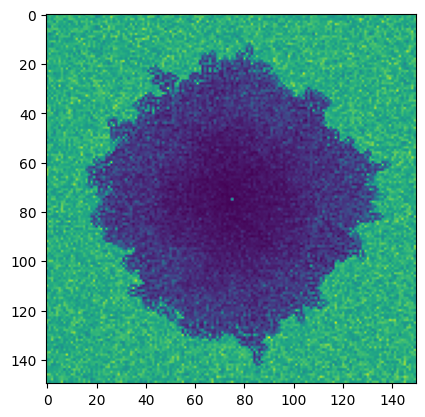

In [5]:
cnn.eval()
X  = pd.read_parquet('../data/size150_aggregations1000_fad51817-0faf-4f1c-b736-6bd50cb5fdf5.parquet').to_numpy()[-1]
X = X.reshape(1, 1, 150, 150)
X = torch.tensor(X, dtype=torch.float32).to(device)
output = F.softmax(cnn(X), dim=1)
output = output.detach().cpu().numpy()
plt.imshow(output[0].reshape(150, 150));

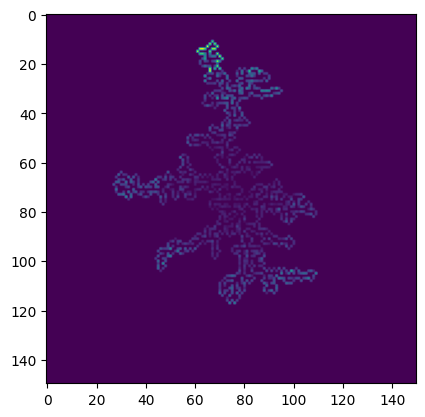

In [6]:
model.eval()
X  = pd.read_parquet('../data/size150_aggregations1000_fad51817-0faf-4f1c-b736-6bd50cb5fdf5.parquet').to_numpy()[-1]
X = X.reshape(1, 1, 150, 150)
X = torch.tensor(X, dtype=torch.float32).to(device)
output = F.softmax(model(X), dim=1)
output = output.detach().cpu().numpy()
plt.imshow(output[0].reshape(150, 150));

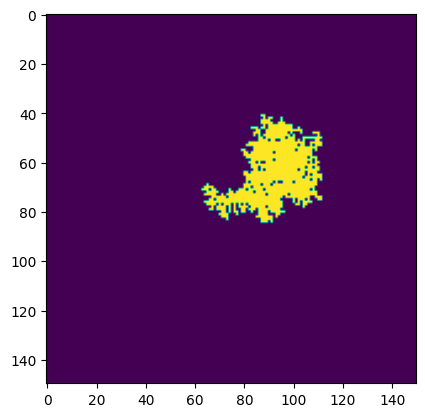

In [14]:
n = 150
grid = np.zeros((1, 1, n, n))
grid[0, 0, n//2, n//2] = 1

for _ in range(1000):
    input = torch.tensor(grid, dtype=torch.float32).to(device)
    output = model(input)
    output = F.softmax(output, dim=1)
    output = output.detach().cpu().numpy().reshape(n*n)
    idx = np.random.choice(n*n, p=output)
    grid[0, 0, idx // n, idx % n] = 1

plt.imshow(grid[0, 0])
plt.show()